In [1]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

In [2]:
ps_conf = ps.SparkConf().set("spark.logConf", "false")\
            .set("spark.executor.memory", "12g")\
            .set("spark.driver.memory", "4g")\
            .set("spark.executor.cores", "7")\
            .set("spark.sql.shuffle.partitions", "500")\
            .set("spark.executor.extraJavaOptions", "-XX:+UseG1GC -XX:+UseStringDeduplication")\
            .set("spark.eventLog.gcMetrics.youngGenerationGarbageCollectors", "G1 Young Generation")\
            .set("spark.eventLog.gcMetrics.oldGenerationGarbageCollectors", "G1 Old Generation")\
			.set("spark.logConf", "false")
spark = SparkSession.builder.config(conf=ps_conf).getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/11 14:57:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [4]:
input_path = SPECIFIED_CSV + "_c-united_config.csv"
df_config  = spark.read.option("inferSchema", "True").option("header", "True").csv(input_path)
df_config.persist(StorageLevel.MEMORY_AND_DISK_DESER)

utid_list = df_config.select("unit_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()
spid_list = df_config.select("shop_id").drop_duplicates().rdd.flatMap(lambda x: x).collect()

In [5]:
#pos data 前処理
input_path  = SPECIFIED_CSV + "_pos_data_table.csv"
df_pos_data = spark.read.option('inferSchema', 'True').option('header', 'True').csv(input_path)\
				.select(
					"shop_id",
                    "レシートＮｏ．",
                    "商品種別",
                    "商品コード",
                    F.regexp_replace(col("商品名称（または券名称）"), "[ 　]", "").alias("商品名称（または券名称）"),
                    "オーダー時刻",
                    "単価",
                    "数量",
                    "合計金額",
                    "date"
				)\
				.filter(col("商品名称（または券名称）") != "")\
				.groupBy("shop_id", "date", "レシートＮｏ．").agg(
                    F.last("オーダー時刻").alias("オーダー時刻"),
                    F.sum(F.when(col("商品種別") == "Y", 1).otherwise(0)).alias("レシートあたりのセット商品の数"),
                    F.sum("数量").alias("総売上点数"),
                    F.sum("合計金額").alias("総売上"),
				)\
                .withColumn("レシートあたりのセット商品の数", F.when(col("レシートあたりのセット商品の数") == 0, 1)
                            								.otherwise(col("レシートあたりのセット商品の数")))\
                .withColumn("オーダー時刻", (F.col("オーダー時刻") / 100).cast("int"))\
                .withColumnRenamed("レシートあたりのセット商品の数", "来店者数")\
                .withColumnRenamed("オーダー時刻", "hour")
df_pos_data = df_pos_data.groupBy("shop_id", "date", "hour").agg(
                    F.sum("来店者数").alias("来店者数"),
                    F.sum("総売上点数").alias("総売上点数"),
                    F.sum("総売上").alias("総売上"),
				)\
                .select(["shop_id", "date", "hour", "来店者数", "総売上点数", "総売上"])\
                .orderBy(col("shop_id").asc(), col("date").asc(), col("hour").asc())
df_pos_data.show()


+-------+----------+----+--------+----------+------+
|shop_id|      date|hour|来店者数|総売上点数|総売上|
+-------+----------+----+--------+----------+------+
|   1189|2023-10-10|   6|       1|         1|   360|
|   1189|2023-10-10|   7|      56|        98| 43340|
|   1189|2023-10-10|   8|      50|        84| 36170|
|   1189|2023-10-10|   9|      66|       404|156520|
|   1189|2023-10-10|  10|      62|       129| 57640|
|   1189|2023-10-10|  11|      52|       120| 66465|
|   1189|2023-10-10|  12|     107|       206| 99340|
|   1189|2023-10-10|  13|      97|       166| 76190|
|   1189|2023-10-10|  14|      92|       185| 90990|
|   1189|2023-10-10|  15|     102|       176| 77170|
|   1189|2023-10-10|  16|     102|       204| 90260|
|   1189|2023-10-10|  17|      69|       174| 80205|
|   1189|2023-10-10|  18|      77|       125| 60590|
|   1189|2023-10-10|  19|      67|       133| 61540|
|   1189|2023-10-10|  20|      41|        74| 34710|
|   1189|2023-10-10|  21|      13|        26| 11895|
|   1

In [6]:
df_pos_data = df_pos_data\
    				.withColumn("date", F.from_unixtime(F.unix_timestamp("date") + F.col("hour") * 3600))\
                    .drop("hour")\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

+-------+-------------------+--------+----------+------+
|shop_id|               date|来店者数|総売上点数|総売上|
+-------+-------------------+--------+----------+------+
|   1189|2023-10-10 06:00:00|       1|         1|   360|
|   1189|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|2023-10-10 09:00:00|      66|       404|156520|
|   1189|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|2023-10-10 15:00:00|     102|       176| 77170|
|   1189|2023-10-10 16:00:00|     102|       204| 90260|
|   1189|2023-10-10 17:00:00|      69|       174| 80205|
|   1189|2023-10-10 18:00:00|      77|       125| 60590|
|   1189|2023-10-10 19:00:00|      67|       133| 61540|
|   1189|2023-10-10 20:00:00|      41|     

In [7]:
df_pos_data = df_pos_data\
					.join(df_config.select(["shop_id", "caption"]), on="shop_id", how="inner")\
                    .select(["shop_id", "caption", "date", "来店者数", "総売上点数", "総売上"])\
                    .orderBy(col("shop_id").asc(), col("date").asc())
df_pos_data.show()

24/10/11 14:57:24 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


+-------+-------------------------------------+-------------------+--------+----------+------+
|shop_id|                              caption|               date|来店者数|総売上点数|総売上|
+-------+-------------------------------------+-------------------+--------+----------+------+
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 06:00:00|       1|         1|   360|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 07:00:00|      56|        98| 43340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 08:00:00|      50|        84| 36170|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 09:00:00|      66|       404|156520|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 10:00:00|      62|       129| 57640|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 11:00:00|      52|       120| 66465|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 12:00:00|     107|       206| 99340|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 13:00:00|      97|       166| 76190|
|   1189|カフェ・ド・クリエグランサンシャイ...|2023-10-10 14:00:00|      92|       185| 90990|
|   1189|カフェ・ド・クリエグランサンシャ

In [8]:
pd_pos_data = df_pos_data.select(["shop_id", "caption", "date", "来店者数"]).toPandas()
pd_pos_data = pd_pos_data[pd_pos_data["shop_id"] == 1189]
pd_pos_data

,shop_id,caption,date,来店者数
0,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 06:00:00,1
1,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 07:00:00,56
2,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 08:00:00,50
3,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 09:00:00,66
4,1189,カフェ・ド・クリエグランサンシャイン通り店,2023-10-10 10:00:00,62
...,...,...,...,...
5355,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 17:00:00,129
5356,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 18:00:00,87
5357,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 19:00:00,73
5358,1189,カフェ・ド・クリエグランサンシャイン通り店,2024-09-15 20:00:00,75


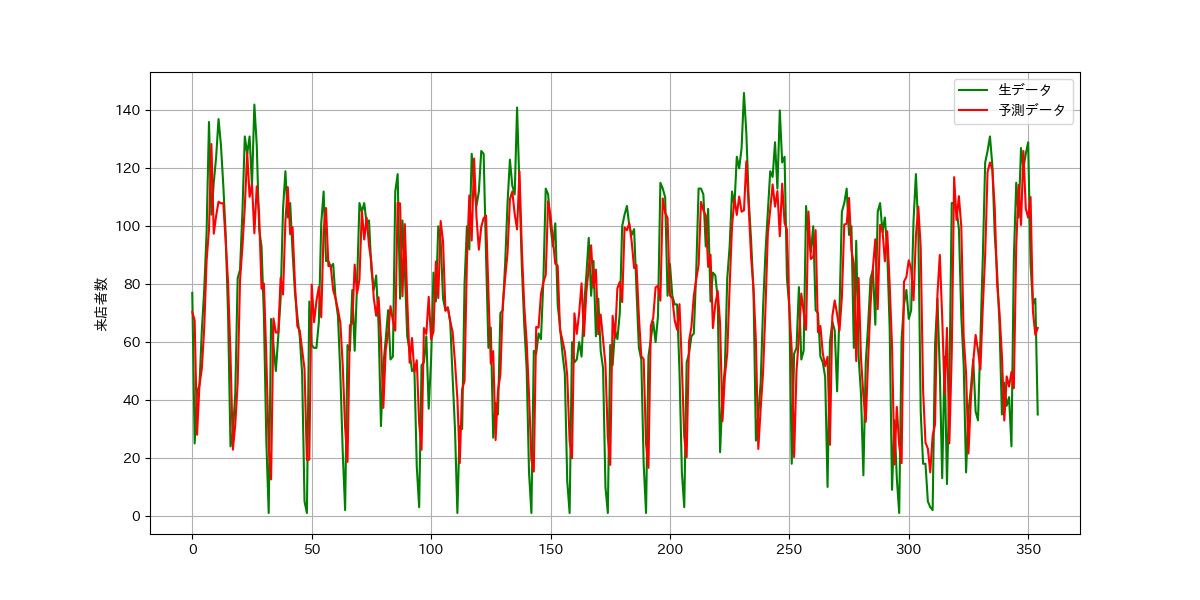

In [9]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

x_reg_data = pd_pos_data[["来店者数"]].values.tolist()
x_reg_train, x_reg_test = x_reg_data[0:5000], x_reg_data[5000:]
lag = 5
ar2 = AutoReg(x_reg_test, lags=lag)
ar2_fit = ar2.fit()

# 予測
pred2 = ar2_fit.predict(start=lag, end=len(x_reg_test)-1)
#pred2 = ar2_fit.forecast(steps=len(x_reg_test))

plt.figure(figsize=(12, 6))
plt.plot(x_reg_test[lag:], "-", color="green", label="生データ")
plt.plot(pred2,            "-", color="red",   label="予測データ")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

In [10]:
ar2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:                     AutoReg(5)   Log Likelihood               -1582.938
Method:               Conditional MLE   S.D. of innovations             20.906
Date:                Fri, 11 Oct 2024   AIC                           3179.876
Time:                        14:57:28   BIC                           3206.981
Sample:                             5   HQIC                          3190.659
                                  360                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.5448      3.531      9.501      0.000      26.625      40.465
y.L1           0.7930      0.052     15.311      0.000       0.692       0.895
y.L2          -0.0309      0.067     -0.462      0.644      -0.162       0.100
y.L3          -0.0313      0.067     -0.469      0.639      -0.162       0.100
y.L4           0.0457      0.067      0.682      0.495      -0.085       0.177
y.L5          -0.2325      0.052     -4.476      0.000      -0.334      -0.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0339           -0.4675j            1.1346           -0.0676
AR.2            1.0339           +0.4675j            1.1346            0.0676
AR.3           -1.5259           -0.0000j            1.5259           -0.5000
AR.4           -0.1727           -1.4697j            1.4798           -0.2686
AR.5           -0.1727           +1.4697j            1.4798            0.2686
-----------------------------------------------------------------------------
"""

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


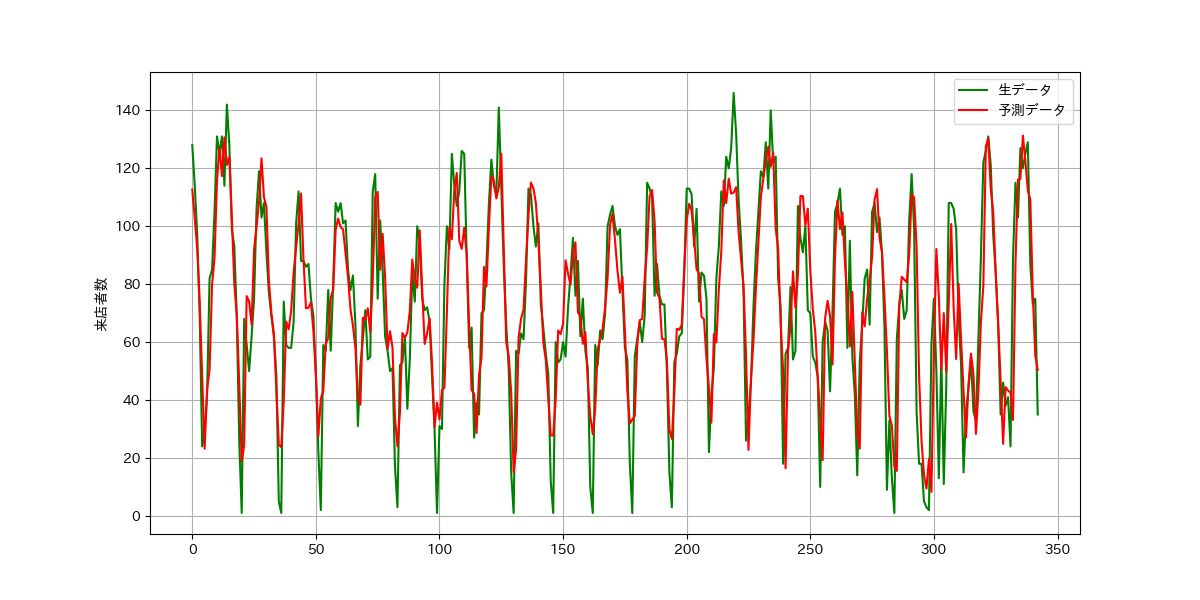

In [11]:
sel = ar_select_order(x_reg_test, maxlag=20)
print(sel.ar_lags)

ar2_fit = sel.model.fit()

# 予測
pred2 = ar2_fit.predict(start=17, end=len(x_reg_test)-1)

plt.figure(figsize=(12, 6))
plt.plot(x_reg_test[17:], "-", color="green", label="生データ")
plt.plot(pred2,            "-", color="red",   label="予測データ")
plt.ylabel("来店者数")
plt.grid(True)
plt.legend()

In [12]:
ar2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  360
Model:                    AutoReg(17)   Log Likelihood               -1473.269
Method:               Conditional MLE   S.D. of innovations             17.749
Date:                Fri, 11 Oct 2024   AIC                           2984.538
Time:                        14:57:29   BIC                           3057.454
Sample:                            17   HQIC                          3013.583
                                  360                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.5479      6.123      2.702      0.007       4.547      28.549
y.L1           0.5822      0.053     11.060      0.000       0.479       0.685
y.L2           0.0233      0.061      0.382      0.702      -0.096       0.142
y.L3          -0.0358      0.059     -0.603      0.547      -0.152       0.081
y.L4           0.0436      0.059      0.733      0.464      -0.073       0.160
y.L5           0.0081      0.059      0.136      0.892      -0.108       0.125
y.L6          -0.0835      0.059     -1.404      0.160      -0.200       0.033
y.L7           0.0543      0.059      0.913      0.361      -0.062       0.171
y.L8          -0.0811      0.060     -1.358      0.174      -0.198       0.036
y.L9          -0.0913      0.060     -1.527      0.127      -0.208       0.026
y.L10          0.0176      0.060      0.294      0.769      -0.100       0.135
y.L11          0.0838      0.060      1.405      0.160      -0.033       0.201
y.L12          0.0209      0.060      0.349      0.727      -0.097       0.138
y.L13          0.0246      0.060      0.411      0.681      -0.093       0.142
y.L14          0.0138      0.060      0.231      0.817      -0.104       0.131
y.L15          0.2475      0.060      4.141      0.000       0.130       0.365
y.L16          0.1675      0.061      2.735      0.006       0.047       0.288
y.L17         -0.2235      0.053     -4.223      0.000      -0.327      -0.120
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1532           -0.0000j            1.1532           -0.5000
AR.2            -1.0379           -0.3899j            1.1087           -0.4428
AR.3            -1.0379           +0.3899j            1.1087            0.4428
AR.4            -0.8150           -0.7247j            1.0906           -0.3843
AR.5            -0.8150           +0.7247j            1.0906            0.3843
AR.6            -0.4561           -0.9936j            1.0933           -0.3185
AR.7            -0.4561           +0.9936j            1.0933            0.3185
AR.8            -0.0542           -1.0414j            1.0428           -0.2583
AR.9            -0.0542           +1.0414j            1.0428            0.2583
AR.10            0.3812           -0.9763j            1.0481           -0.1907
AR.11            0.3812           +0.9763j            1.0481            0.1907
AR.12            0.7089           -0.7871j            1.0593           -0.1333
AR.13            0.7089           +0.7871j            1.0593            0.1333
AR.14            0.9243           -0.4049j            1.0091           -0.0657
AR.15            0.9243           +0.4049j            1.0091            0.0657
AR.16            1.0479           -0.0000j            1.0479           -0.0000
AR